In [5]:
import os
import cv2
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from tqdm import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms

from skimage import filters, color
from skimage.io import imread


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# Define the paths
data_dir = '/kaggle/input/skin-cancer-isic-images'
benign_dir = os.path.join(data_dir, 'benign')
malignant_dir = os.path.join(data_dir, 'malignant')


# Dataset Classes

In [7]:
class BaseDataset(Dataset):
    def __init__(self, data_dir):
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(["benign", "malignant"]):
            class_dir = os.path.join(data_dir, class_name)
            for image_name in os.listdir(class_dir):
                self.image_paths.append(os.path.join(class_dir, image_name))
                self.labels.append(label)
        self.samples = list(zip(self.image_paths, self.labels))
        self.classes = ["benign", "malignant"]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        return img_path, label

    
class TransformDataset(Dataset):
    def __init__(self, base_dataset, transform):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        img_path, label = self.base_dataset[idx]
        
        # Load and preprocess the image
        img = Image.open(img_path).convert('RGB')
        # img = remove_hair(img)  # Remove hair (returns a NumPy array)
        # img = enhance_contrast(img)  # Enhance contrast (returns a NumPy array)
        # img = Image.fromarray(img)  # Convert NumPy array back to PIL Image
        
        # Apply the transformation
        if self.transform:
            img = self.transform(img)
        
        return img, label


## Define base Transformations

In [8]:
# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ColorJitter(contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop((224, 224), scale=(0.7, 1.0)),  # ZoomOut
        transforms.RandomRotation(20),
        transforms.RandomAffine(0, shear=10, translate=(0.2, 0.2)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [9]:
# Base dataset with all data
data_dir = '/kaggle/input/skin-cancer-isic-images'
base_dataset = BaseDataset(data_dir)

# Compute split sizes
train_size = int(0.8 * len(base_dataset))
val_size = int(0.1 * len(base_dataset))
test_size = len(base_dataset) - train_size - val_size

# Split into train, validation, and test datasets
train_base, val_base, test_base = random_split(base_dataset, [train_size, val_size, test_size])

# Apply transformations to each subset
train_dataset = TransformDataset(train_base, transform=data_transforms['train'])
val_dataset = TransformDataset(val_base, transform=data_transforms['val'])
test_dataset = TransformDataset(test_base, transform=data_transforms['test'])

## EDA

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


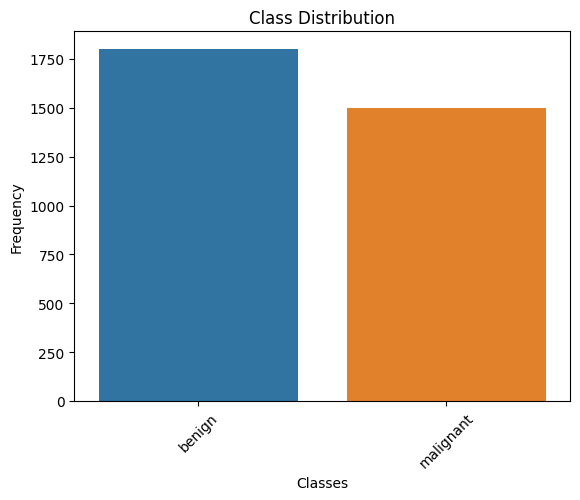

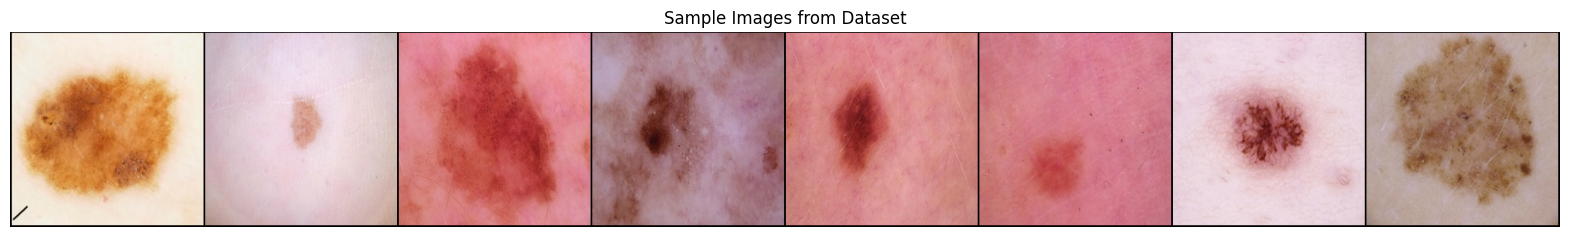

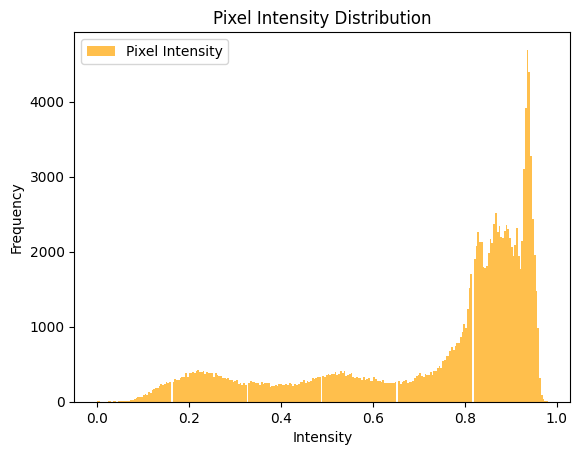

In [10]:
from torchvision.utils import make_grid

# Class Distribution
def plot_class_distribution(dataset):
    # Get the labels from the dataset's samples
    labels = [item[1] for item in dataset.samples]
    # Map the labels to class names using the dataset classes
    class_names = dataset.classes
    class_labels = [class_names[label] for label in labels]
    
    # Plot the distribution
    sns.countplot(x=class_labels)
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

# Display some images from the dataset
def display_sample_images(dataset, n=8):
    from torchvision.transforms.functional import to_tensor

    images, labels = [], []
    for i in range(n):
        img_path, label = dataset[i]  # Retrieve image path and label
        img = Image.open(img_path).convert('RGB')  # Load image
        img_tensor = to_tensor(img)  # Convert to tensor
        images.append(img_tensor)
        labels.append(label)

    grid_img = make_grid(images, nrow=n, normalize=True)
    plt.figure(figsize=(20, 5))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title("Sample Images from Dataset")
    plt.axis('off')
    plt.show()


# Plot Pixel Intensity Distribution
def plot_pixel_intensity_distribution(dataset):
    from torchvision.transforms.functional import to_tensor

    img_path, _ = dataset[0]  # Get the first image path
    img = Image.open(img_path).convert('RGB')  # Load image
    img_tensor = to_tensor(img)  # Convert to tensor
    pixels = img_tensor.numpy().ravel()  # Flatten the tensor
    plt.hist(pixels, bins=256, color='orange', alpha=0.7, label='Pixel Intensity')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()


# EDA Execution
plot_class_distribution(base_dataset)
display_sample_images(base_dataset, n=8)
plot_pixel_intensity_distribution(base_dataset)


## Additional Processing

In [11]:
def remove_hair(img):
    img = np.array(img)  # Convert PIL image to NumPy array
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)  # Convert to grayscale using OpenCV
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, thresh = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    inpaint = cv2.inpaint(img, thresh, inpaintRadius=1, flags=cv2.INPAINT_TELEA)
    return inpaint  # Return as NumPy array

def enhance_contrast(img):
    img = np.array(img)  # Convert PIL image to NumPy array
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)  # Convert to LAB color space
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_enhanced = clahe.apply(l)
    enhanced_img = cv2.merge((l_enhanced, a, b))
    return cv2.cvtColor(enhanced_img, cv2.COLOR_LAB2RGB)  # Convert back to RGB

## Integrated Data Transformations

In [12]:

# DataLoader instances
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)


## Define the Model Architecture

In [13]:
# Define the model architecture
class SkinCancerModel(nn.Module):
    def __init__(self):
        super(SkinCancerModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            # nn.Dropout(0.3),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


## Training and Evaluation of Base Model

In [14]:
# Training loop with early stopping and learning rate scheduler
def train_model(model, train_loader, val_loader, epochs=10, patience=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_val_loss = float('inf')
    patience_counter = 0
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    
    # Scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

    # Move model to device
    model = model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        val_loss /= len(val_loader)
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")
            print("Validation loss improved. Model saved.")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}")

        # if patience_counter >= patience:
        #     print("Early stopping triggered.")
        #     break

        # Step the scheduler
        scheduler.step(val_loss)

    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    print("Loaded best model from checkpoint.")

    # Plot train/validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [15]:
model = SkinCancerModel().to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 1/50, Train Loss: 0.6419, Train Accuracy: 0.6276


Validation Loss: 0.6086, Validation Accuracy: 0.6930
Validation loss improved. Model saved.


Epoch 2/50: 100%|██████████| 42/42 [00:09<00:00,  4.21it/s]

Epoch 2/50, Train Loss: 0.6043, Train Accuracy: 0.6837


Validation Loss: 0.6051, Validation Accuracy: 0.7143
Validation loss improved. Model saved.


Epoch 3/50: 100%|██████████| 42/42 [00:10<00:00,  4.19it/s]

Epoch 3/50, Train Loss: 0.5783, Train Accuracy: 0.6951


Validation Loss: 0.5850, Validation Accuracy: 0.7325
Validation loss improved. Model saved.


Epoch 4/50: 100%|██████████| 42/42 [00:10<00:00,  3.89it/s]

Epoch 4/50, Train Loss: 0.5837, Train Accuracy: 0.6974


Validation Loss: 0.6020, Validation Accuracy: 0.7295
No improvement in validation loss. Patience counter: 1


Epoch 5/50: 100%|██████████| 42/42 [00:09<00:00,  4.35it/s]

Epoch 5/50, Train Loss: 0.5754, Train Accuracy: 0.7019


Validation Loss: 0.5880, Validation Accuracy: 0.7356
No improvement in validation loss. Patience counter: 2


Epoch 6/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 6/50, Train Loss: 0.5642, Train Accuracy: 0.7084


Validation Loss: 0.5449, Validation Accuracy: 0.7143
Validation loss improved. Model saved.


Epoch 7/50: 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]

Epoch 7/50, Train Loss: 0.5506, Train Accuracy: 0.7084


Validation Loss: 0.5293, Validation Accuracy: 0.7325
Validation loss improved. Model saved.


Epoch 8/50: 100%|██████████| 42/42 [00:09<00:00,  4.30it/s]

Epoch 8/50, Train Loss: 0.5379, Train Accuracy: 0.7201


Validation Loss: 0.5316, Validation Accuracy: 0.7295
No improvement in validation loss. Patience counter: 1


Epoch 9/50: 100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

Epoch 9/50, Train Loss: 0.5527, Train Accuracy: 0.7004


Validation Loss: 0.5116, Validation Accuracy: 0.7477
Validation loss improved. Model saved.


Epoch 10/50: 100%|██████████| 42/42 [00:10<00:00,  4.15it/s]

Epoch 10/50, Train Loss: 0.5189, Train Accuracy: 0.7277


Validation Loss: 0.4894, Validation Accuracy: 0.7872
Validation loss improved. Model saved.


Epoch 11/50: 100%|██████████| 42/42 [00:09<00:00,  4.22it/s]

Epoch 11/50, Train Loss: 0.5411, Train Accuracy: 0.7273


Validation Loss: 0.5047, Validation Accuracy: 0.7173
No improvement in validation loss. Patience counter: 1


Epoch 12/50: 100%|██████████| 42/42 [00:09<00:00,  4.31it/s]

Epoch 12/50, Train Loss: 0.5058, Train Accuracy: 0.7512


Validation Loss: 0.4509, Validation Accuracy: 0.8055
Validation loss improved. Model saved.


Epoch 13/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 13/50, Train Loss: 0.4860, Train Accuracy: 0.7577


Validation Loss: 0.4542, Validation Accuracy: 0.7599
No improvement in validation loss. Patience counter: 1


Epoch 14/50: 100%|██████████| 42/42 [00:09<00:00,  4.30it/s]

Epoch 14/50, Train Loss: 0.5023, Train Accuracy: 0.7414


Validation Loss: 0.4724, Validation Accuracy: 0.7629
No improvement in validation loss. Patience counter: 2


Epoch 15/50: 100%|██████████| 42/42 [00:09<00:00,  4.32it/s]

Epoch 15/50, Train Loss: 0.4885, Train Accuracy: 0.7683


Validation Loss: 0.4417, Validation Accuracy: 0.8024
Validation loss improved. Model saved.


Epoch 16/50: 100%|██████████| 42/42 [00:10<00:00,  4.08it/s]

Epoch 16/50, Train Loss: 0.4750, Train Accuracy: 0.7634


Validation Loss: 0.4246, Validation Accuracy: 0.8024
Validation loss improved. Model saved.


Epoch 17/50: 100%|██████████| 42/42 [00:09<00:00,  4.29it/s]

Epoch 17/50, Train Loss: 0.4829, Train Accuracy: 0.7581


Validation Loss: 0.4297, Validation Accuracy: 0.7781
No improvement in validation loss. Patience counter: 1


Epoch 18/50: 100%|██████████| 42/42 [00:09<00:00,  4.28it/s]

Epoch 18/50, Train Loss: 0.4486, Train Accuracy: 0.7759


Validation Loss: 0.4222, Validation Accuracy: 0.7964
Validation loss improved. Model saved.


Epoch 19/50: 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]

Epoch 19/50, Train Loss: 0.4415, Train Accuracy: 0.7846


Validation Loss: 0.4096, Validation Accuracy: 0.7994
Validation loss improved. Model saved.


Epoch 20/50: 100%|██████████| 42/42 [00:09<00:00,  4.27it/s]

Epoch 20/50, Train Loss: 0.4246, Train Accuracy: 0.7983


Validation Loss: 0.4027, Validation Accuracy: 0.8237
Validation loss improved. Model saved.


Epoch 21/50: 100%|██████████| 42/42 [00:09<00:00,  4.32it/s]

Epoch 21/50, Train Loss: 0.4175, Train Accuracy: 0.8005


Validation Loss: 0.4072, Validation Accuracy: 0.8419
No improvement in validation loss. Patience counter: 1


Epoch 22/50: 100%|██████████| 42/42 [00:10<00:00,  4.01it/s]

Epoch 22/50, Train Loss: 0.4412, Train Accuracy: 0.7838


Validation Loss: 0.4020, Validation Accuracy: 0.8359
Validation loss improved. Model saved.


Epoch 23/50: 100%|██████████| 42/42 [00:09<00:00,  4.35it/s]

Epoch 23/50, Train Loss: 0.3957, Train Accuracy: 0.8119


Validation Loss: 0.4564, Validation Accuracy: 0.8207
No improvement in validation loss. Patience counter: 1


Epoch 24/50: 100%|██████████| 42/42 [00:09<00:00,  4.29it/s]

Epoch 24/50, Train Loss: 0.4138, Train Accuracy: 0.8039


Validation Loss: 0.4036, Validation Accuracy: 0.7933
No improvement in validation loss. Patience counter: 2


Epoch 25/50: 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]

Epoch 25/50, Train Loss: 0.4029, Train Accuracy: 0.8077


Validation Loss: 0.3950, Validation Accuracy: 0.8328
Validation loss improved. Model saved.


Epoch 26/50: 100%|██████████| 42/42 [00:09<00:00,  4.33it/s]

Epoch 26/50, Train Loss: 0.3909, Train Accuracy: 0.8096


Validation Loss: 0.3989, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 1


Epoch 27/50: 100%|██████████| 42/42 [00:09<00:00,  4.22it/s]

Epoch 27/50, Train Loss: 0.4201, Train Accuracy: 0.7960


Validation Loss: 0.4039, Validation Accuracy: 0.8116
No improvement in validation loss. Patience counter: 2


Epoch 28/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 28/50, Train Loss: 0.3855, Train Accuracy: 0.8161


Validation Loss: 0.3897, Validation Accuracy: 0.8328
Validation loss improved. Model saved.


Epoch 29/50: 100%|██████████| 42/42 [00:10<00:00,  4.15it/s]

Epoch 29/50, Train Loss: 0.4000, Train Accuracy: 0.8077


Validation Loss: 0.3821, Validation Accuracy: 0.8419
Validation loss improved. Model saved.


Epoch 30/50: 100%|██████████| 42/42 [00:09<00:00,  4.25it/s]

Epoch 30/50, Train Loss: 0.3815, Train Accuracy: 0.8195


Validation Loss: 0.4145, Validation Accuracy: 0.8267
No improvement in validation loss. Patience counter: 1


Epoch 31/50: 100%|██████████| 42/42 [00:10<00:00,  3.88it/s]

Epoch 31/50, Train Loss: 0.3864, Train Accuracy: 0.8191


Validation Loss: 0.3714, Validation Accuracy: 0.8328
Validation loss improved. Model saved.


Epoch 32/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 32/50, Train Loss: 0.3927, Train Accuracy: 0.8184


Validation Loss: 0.3942, Validation Accuracy: 0.8328
No improvement in validation loss. Patience counter: 1


Epoch 33/50: 100%|██████████| 42/42 [00:09<00:00,  4.23it/s]

Epoch 33/50, Train Loss: 0.3890, Train Accuracy: 0.8165


Validation Loss: 0.3864, Validation Accuracy: 0.8085
No improvement in validation loss. Patience counter: 2


Epoch 34/50: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]

Epoch 34/50, Train Loss: 0.3818, Train Accuracy: 0.8221


Validation Loss: 0.4059, Validation Accuracy: 0.8146
No improvement in validation loss. Patience counter: 3


Epoch 35/50: 100%|██████████| 42/42 [00:10<00:00,  4.16it/s]

Epoch 35/50, Train Loss: 0.3602, Train Accuracy: 0.8331


Validation Loss: 0.3826, Validation Accuracy: 0.8237
No improvement in validation loss. Patience counter: 4


Epoch 36/50: 100%|██████████| 42/42 [00:10<00:00,  4.11it/s]

Epoch 36/50, Train Loss: 0.3696, Train Accuracy: 0.8335


Validation Loss: 0.3914, Validation Accuracy: 0.8237
No improvement in validation loss. Patience counter: 5


Epoch 37/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 37/50, Train Loss: 0.3582, Train Accuracy: 0.8206


Validation Loss: 0.3852, Validation Accuracy: 0.8267
No improvement in validation loss. Patience counter: 6


Epoch 38/50: 100%|██████████| 42/42 [00:09<00:00,  4.24it/s]

Epoch 38/50, Train Loss: 0.3545, Train Accuracy: 0.8403


Validation Loss: 0.3854, Validation Accuracy: 0.8237
No improvement in validation loss. Patience counter: 7


Epoch 39/50: 100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

Epoch 39/50, Train Loss: 0.3591, Train Accuracy: 0.8354


Validation Loss: 0.3874, Validation Accuracy: 0.8207
No improvement in validation loss. Patience counter: 8


Epoch 40/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 40/50, Train Loss: 0.3556, Train Accuracy: 0.8362


Validation Loss: 0.3891, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 9


Epoch 41/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 41/50, Train Loss: 0.3573, Train Accuracy: 0.8354


Validation Loss: 0.3890, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 10


Epoch 42/50: 100%|██████████| 42/42 [00:09<00:00,  4.29it/s]

Epoch 42/50, Train Loss: 0.3665, Train Accuracy: 0.8297


Validation Loss: 0.3889, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 11


Epoch 43/50: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]

Epoch 43/50, Train Loss: 0.3595, Train Accuracy: 0.8206


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 12


Epoch 44/50: 100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

Epoch 44/50, Train Loss: 0.3554, Train Accuracy: 0.8309


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 13


Epoch 45/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 45/50, Train Loss: 0.3635, Train Accuracy: 0.8267


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 14


Epoch 46/50: 100%|██████████| 42/42 [00:10<00:00,  3.89it/s]

Epoch 46/50, Train Loss: 0.3473, Train Accuracy: 0.8381


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 15


Epoch 47/50: 100%|██████████| 42/42 [00:10<00:00,  4.20it/s]

Epoch 47/50, Train Loss: 0.3609, Train Accuracy: 0.8335


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 16


Epoch 48/50: 100%|██████████| 42/42 [00:09<00:00,  4.20it/s]

Epoch 48/50, Train Loss: 0.3544, Train Accuracy: 0.8309


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 17


Epoch 49/50: 100%|██████████| 42/42 [00:11<00:00,  3.82it/s]

Epoch 49/50, Train Loss: 0.3584, Train Accuracy: 0.8297


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 18


Epoch 50/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 50/50, Train Loss: 0.3532, Train Accuracy: 0.8259


Validation Loss: 0.3888, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 19
Loaded best model from checkpoint.


/tmp/ipykernel_17824/2544829555.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


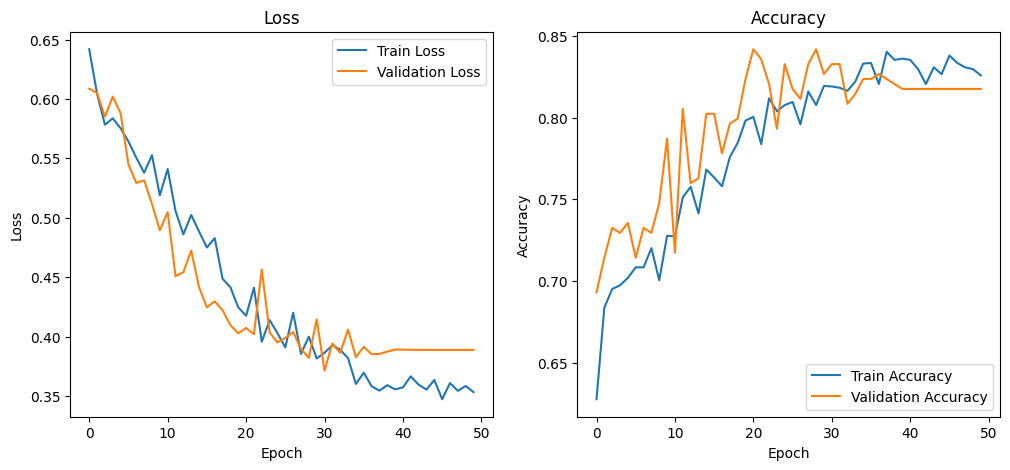

In [16]:
# Train the model
train_model(model, train_loader, val_loader, epochs=50)


Test Loss: 0.3505, Test Accuracy: 0.8218


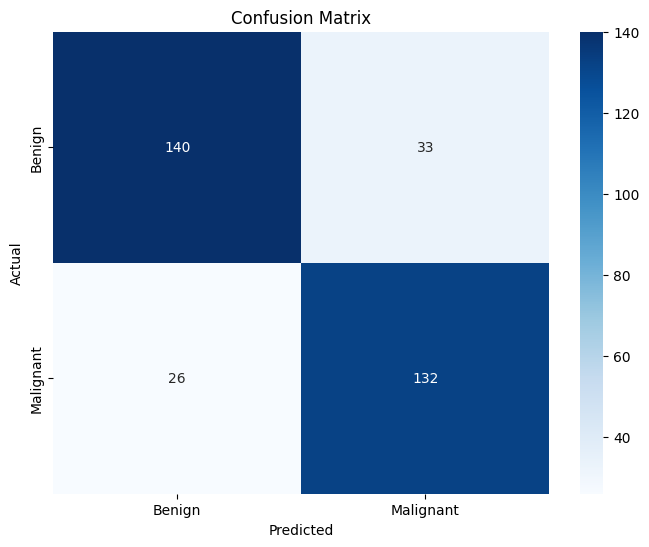

              precision    recall  f1-score   support

      Benign       0.84      0.81      0.83       173
   Malignant       0.80      0.84      0.82       158

    accuracy                           0.82       331
   macro avg       0.82      0.82      0.82       331
weighted avg       0.82      0.82      0.82       331



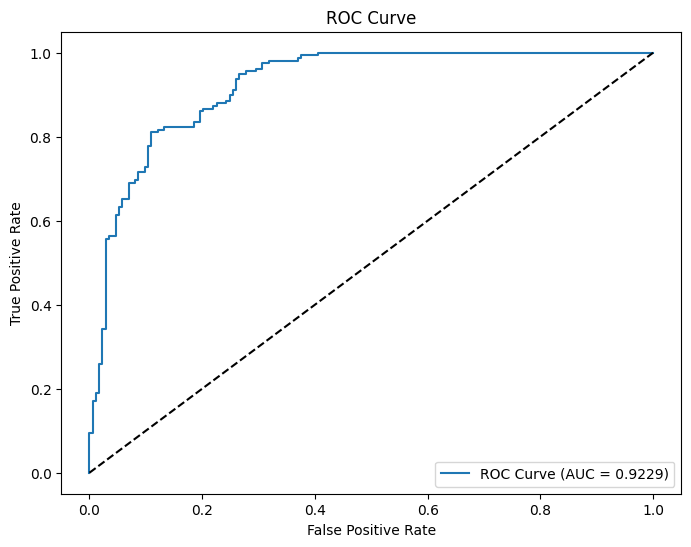

In [17]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Testing and metrics
def evaluate_model(model, test_loader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # Classification Metrics
    print(classification_report(all_labels, all_preds, target_names=['Benign', 'Malignant']))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

evaluate_model(model, test_loader)

## Training and Evaluation of Modefied Model


In [24]:
class SkinCancerModel2(nn.Module):
    def __init__(self):
        super(SkinCancerModel2, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),            
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=3),
            # nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AvgPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3),
            # nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(18432, 64),
            nn.ReLU(),
                # nn.Dropout(0.3),
            # nn.Linear(64, 32),
            # nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [25]:
model2 = SkinCancerModel2().to(device)

# # Loss and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model2.parameters(), lr=0.0001)

# # Scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)


Epoch 1/50: 100%|██████████| 42/42 [00:10<00:00,  4.08it/s]

Epoch 1/50, Train Loss: 0.6375, Train Accuracy: 0.6553


Validation Loss: 0.5792, Validation Accuracy: 0.7416
Validation loss improved. Model saved.


Epoch 2/50: 100%|██████████| 42/42 [00:10<00:00,  4.06it/s]

Epoch 2/50, Train Loss: 0.5728, Train Accuracy: 0.6966


Validation Loss: 0.5336, Validation Accuracy: 0.7599
Validation loss improved. Model saved.


Epoch 3/50: 100%|██████████| 42/42 [00:10<00:00,  4.19it/s]

Epoch 3/50, Train Loss: 0.5608, Train Accuracy: 0.7107


Validation Loss: 0.5321, Validation Accuracy: 0.7629
Validation loss improved. Model saved.


Epoch 4/50: 100%|██████████| 42/42 [00:09<00:00,  4.21it/s]

Epoch 4/50, Train Loss: 0.5672, Train Accuracy: 0.7019


Validation Loss: 0.5142, Validation Accuracy: 0.7660
Validation loss improved. Model saved.


Epoch 5/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 5/50, Train Loss: 0.5337, Train Accuracy: 0.7262


Validation Loss: 0.5054, Validation Accuracy: 0.7660
Validation loss improved. Model saved.


Epoch 6/50: 100%|██████████| 42/42 [00:09<00:00,  4.22it/s]

Epoch 6/50, Train Loss: 0.5337, Train Accuracy: 0.7163


Validation Loss: 0.5821, Validation Accuracy: 0.7538
No improvement in validation loss. Patience counter: 1


Epoch 7/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 7/50, Train Loss: 0.5512, Train Accuracy: 0.6989


Validation Loss: 0.4681, Validation Accuracy: 0.7629
Validation loss improved. Model saved.


Epoch 8/50: 100%|██████████| 42/42 [00:10<00:00,  4.06it/s]

Epoch 8/50, Train Loss: 0.5360, Train Accuracy: 0.7205


Validation Loss: 0.4851, Validation Accuracy: 0.7812
No improvement in validation loss. Patience counter: 1


Epoch 9/50: 100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

Epoch 9/50, Train Loss: 0.5283, Train Accuracy: 0.7383


Validation Loss: 0.5127, Validation Accuracy: 0.7781
No improvement in validation loss. Patience counter: 2


Epoch 10/50: 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]

Epoch 10/50, Train Loss: 0.5128, Train Accuracy: 0.7361


Validation Loss: 0.4918, Validation Accuracy: 0.7720
No improvement in validation loss. Patience counter: 3


Epoch 11/50: 100%|██████████| 42/42 [00:10<00:00,  4.01it/s]

Epoch 11/50, Train Loss: 0.5232, Train Accuracy: 0.7311


Validation Loss: 0.4585, Validation Accuracy: 0.8085
Validation loss improved. Model saved.


Epoch 12/50: 100%|██████████| 42/42 [00:10<00:00,  4.19it/s]

Epoch 12/50, Train Loss: 0.5053, Train Accuracy: 0.7543


Validation Loss: 0.4434, Validation Accuracy: 0.8024
Validation loss improved. Model saved.


Epoch 13/50: 100%|██████████| 42/42 [00:09<00:00,  4.26it/s]

Epoch 13/50, Train Loss: 0.4908, Train Accuracy: 0.7615


Validation Loss: 0.4392, Validation Accuracy: 0.8116
Validation loss improved. Model saved.


Epoch 14/50: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]

Epoch 14/50, Train Loss: 0.4849, Train Accuracy: 0.7527


Validation Loss: 0.4327, Validation Accuracy: 0.8116
Validation loss improved. Model saved.


Epoch 15/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 15/50, Train Loss: 0.4825, Train Accuracy: 0.7611


Validation Loss: 0.4260, Validation Accuracy: 0.8146
Validation loss improved. Model saved.


Epoch 16/50: 100%|██████████| 42/42 [00:10<00:00,  4.16it/s]

Epoch 16/50, Train Loss: 0.4717, Train Accuracy: 0.7645


Validation Loss: 0.4331, Validation Accuracy: 0.8116
No improvement in validation loss. Patience counter: 1


Epoch 17/50: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]

Epoch 17/50, Train Loss: 0.4649, Train Accuracy: 0.7732


Validation Loss: 0.4367, Validation Accuracy: 0.8116
No improvement in validation loss. Patience counter: 2


Epoch 18/50: 100%|██████████| 42/42 [00:10<00:00,  4.19it/s]

Epoch 18/50, Train Loss: 0.4700, Train Accuracy: 0.7649


Validation Loss: 0.4191, Validation Accuracy: 0.8146
Validation loss improved. Model saved.


Epoch 19/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 19/50, Train Loss: 0.4477, Train Accuracy: 0.7755


Validation Loss: 0.4060, Validation Accuracy: 0.8237
Validation loss improved. Model saved.


Epoch 20/50: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]

Epoch 20/50, Train Loss: 0.4465, Train Accuracy: 0.7816


Validation Loss: 0.4138, Validation Accuracy: 0.8116
No improvement in validation loss. Patience counter: 1


Epoch 21/50: 100%|██████████| 42/42 [00:10<00:00,  4.15it/s]

Epoch 21/50, Train Loss: 0.4521, Train Accuracy: 0.7782


Validation Loss: 0.4018, Validation Accuracy: 0.8267
Validation loss improved. Model saved.


Epoch 22/50: 100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

Epoch 22/50, Train Loss: 0.4447, Train Accuracy: 0.7763


Validation Loss: 0.4084, Validation Accuracy: 0.8085
No improvement in validation loss. Patience counter: 1


Epoch 23/50: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]

Epoch 23/50, Train Loss: 0.4456, Train Accuracy: 0.7835


Validation Loss: 0.4178, Validation Accuracy: 0.8207
No improvement in validation loss. Patience counter: 2


Epoch 24/50: 100%|██████████| 42/42 [00:09<00:00,  4.23it/s]

Epoch 24/50, Train Loss: 0.4363, Train Accuracy: 0.7861


Validation Loss: 0.3965, Validation Accuracy: 0.8116
Validation loss improved. Model saved.


Epoch 25/50: 100%|██████████| 42/42 [00:10<00:00,  4.16it/s]

Epoch 25/50, Train Loss: 0.4411, Train Accuracy: 0.7911


Validation Loss: 0.3870, Validation Accuracy: 0.8419
Validation loss improved. Model saved.


Epoch 26/50: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]

Epoch 26/50, Train Loss: 0.4311, Train Accuracy: 0.7876


Validation Loss: 0.3971, Validation Accuracy: 0.8328
No improvement in validation loss. Patience counter: 1


Epoch 27/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 27/50, Train Loss: 0.4397, Train Accuracy: 0.7827


Validation Loss: 0.3930, Validation Accuracy: 0.8298
No improvement in validation loss. Patience counter: 2


Epoch 28/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 28/50, Train Loss: 0.4286, Train Accuracy: 0.7911


Validation Loss: 0.3937, Validation Accuracy: 0.8176
No improvement in validation loss. Patience counter: 3


Epoch 29/50: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]

Epoch 29/50, Train Loss: 0.4368, Train Accuracy: 0.7888


Validation Loss: 0.3909, Validation Accuracy: 0.8298
No improvement in validation loss. Patience counter: 4


Epoch 30/50: 100%|██████████| 42/42 [00:09<00:00,  4.27it/s]

Epoch 30/50, Train Loss: 0.4226, Train Accuracy: 0.7892


Validation Loss: 0.3867, Validation Accuracy: 0.8328
Validation loss improved. Model saved.


Epoch 31/50: 100%|██████████| 42/42 [00:09<00:00,  4.21it/s]

Epoch 31/50, Train Loss: 0.4177, Train Accuracy: 0.7941


Validation Loss: 0.3873, Validation Accuracy: 0.8419
No improvement in validation loss. Patience counter: 1


Epoch 32/50: 100%|██████████| 42/42 [00:10<00:00,  3.97it/s]

Epoch 32/50, Train Loss: 0.4233, Train Accuracy: 0.7884


Validation Loss: 0.3875, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 2


Epoch 33/50: 100%|██████████| 42/42 [00:09<00:00,  4.20it/s]

Epoch 33/50, Train Loss: 0.4270, Train Accuracy: 0.7971


Validation Loss: 0.3893, Validation Accuracy: 0.8359
No improvement in validation loss. Patience counter: 3


Epoch 34/50: 100%|██████████| 42/42 [00:10<00:00,  4.12it/s]

Epoch 34/50, Train Loss: 0.4183, Train Accuracy: 0.8013


Validation Loss: 0.3891, Validation Accuracy: 0.8328
No improvement in validation loss. Patience counter: 4


Epoch 35/50: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]

Epoch 35/50, Train Loss: 0.4151, Train Accuracy: 0.8013


Validation Loss: 0.3865, Validation Accuracy: 0.8328
Validation loss improved. Model saved.


Epoch 36/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 36/50, Train Loss: 0.4331, Train Accuracy: 0.7865


Validation Loss: 0.3890, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 1


Epoch 37/50: 100%|██████████| 42/42 [00:10<00:00,  4.14it/s]

Epoch 37/50, Train Loss: 0.4272, Train Accuracy: 0.7914


Validation Loss: 0.3897, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 2


Epoch 38/50: 100%|██████████| 42/42 [00:10<00:00,  4.00it/s]

Epoch 38/50, Train Loss: 0.4230, Train Accuracy: 0.7967


Validation Loss: 0.3905, Validation Accuracy: 0.8267
No improvement in validation loss. Patience counter: 3


Epoch 39/50: 100%|██████████| 42/42 [00:10<00:00,  4.18it/s]

Epoch 39/50, Train Loss: 0.4249, Train Accuracy: 0.7880


Validation Loss: 0.3880, Validation Accuracy: 0.8359
No improvement in validation loss. Patience counter: 4


Epoch 40/50: 100%|██████████| 42/42 [00:09<00:00,  4.21it/s]

Epoch 40/50, Train Loss: 0.4231, Train Accuracy: 0.7929


Validation Loss: 0.3892, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 5


Epoch 41/50: 100%|██████████| 42/42 [00:10<00:00,  4.02it/s]

Epoch 41/50, Train Loss: 0.4101, Train Accuracy: 0.8039


Validation Loss: 0.3894, Validation Accuracy: 0.8328
No improvement in validation loss. Patience counter: 6


Epoch 42/50: 100%|██████████| 42/42 [00:10<00:00,  4.20it/s]

Epoch 42/50, Train Loss: 0.4264, Train Accuracy: 0.7907


Validation Loss: 0.3898, Validation Accuracy: 0.8419
No improvement in validation loss. Patience counter: 7


Epoch 43/50: 100%|██████████| 42/42 [00:10<00:00,  4.12it/s]

Epoch 43/50, Train Loss: 0.4207, Train Accuracy: 0.7948


Validation Loss: 0.3889, Validation Accuracy: 0.8298
No improvement in validation loss. Patience counter: 8


Epoch 44/50: 100%|██████████| 42/42 [00:10<00:00,  3.86it/s]

Epoch 44/50, Train Loss: 0.4278, Train Accuracy: 0.8028


Validation Loss: 0.3904, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 9


Epoch 45/50: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]

Epoch 45/50, Train Loss: 0.4157, Train Accuracy: 0.8013


Validation Loss: 0.3886, Validation Accuracy: 0.8359
No improvement in validation loss. Patience counter: 10


Epoch 46/50: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]

Epoch 46/50, Train Loss: 0.4261, Train Accuracy: 0.7922


Validation Loss: 0.3895, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 11


Epoch 47/50: 100%|██████████| 42/42 [00:10<00:00,  4.13it/s]

Epoch 47/50, Train Loss: 0.4188, Train Accuracy: 0.7986


Validation Loss: 0.3905, Validation Accuracy: 0.8267
No improvement in validation loss. Patience counter: 12


Epoch 48/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 48/50, Train Loss: 0.4290, Train Accuracy: 0.7884


Validation Loss: 0.3889, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 13


Epoch 49/50: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]

Epoch 49/50, Train Loss: 0.4251, Train Accuracy: 0.7933


Validation Loss: 0.3880, Validation Accuracy: 0.8419
No improvement in validation loss. Patience counter: 14


Epoch 50/50: 100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

Epoch 50/50, Train Loss: 0.4232, Train Accuracy: 0.7975


Validation Loss: 0.3884, Validation Accuracy: 0.8359
No improvement in validation loss. Patience counter: 15
Loaded best model from checkpoint.


/tmp/ipykernel_17824/2544829555.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


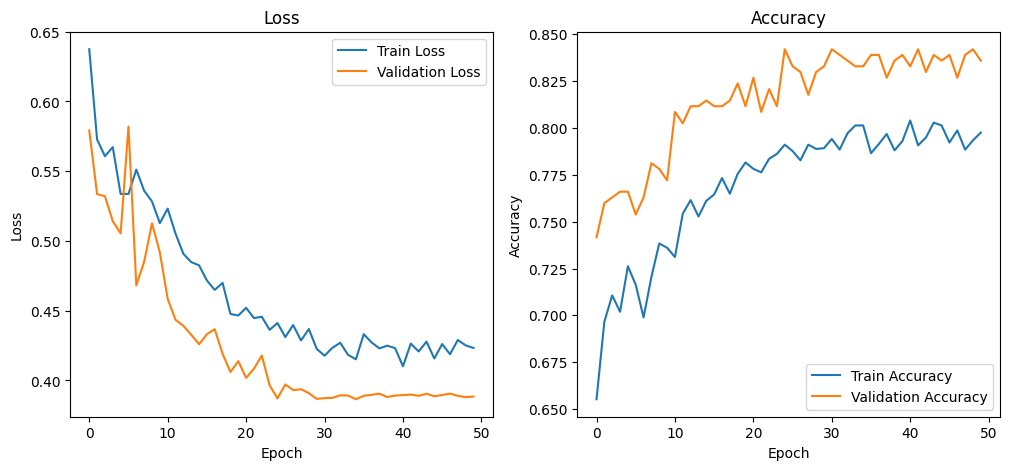

In [26]:
train_model(model2, train_loader, val_loader, epochs=50)

Test Loss: 0.3547, Test Accuracy: 0.8278


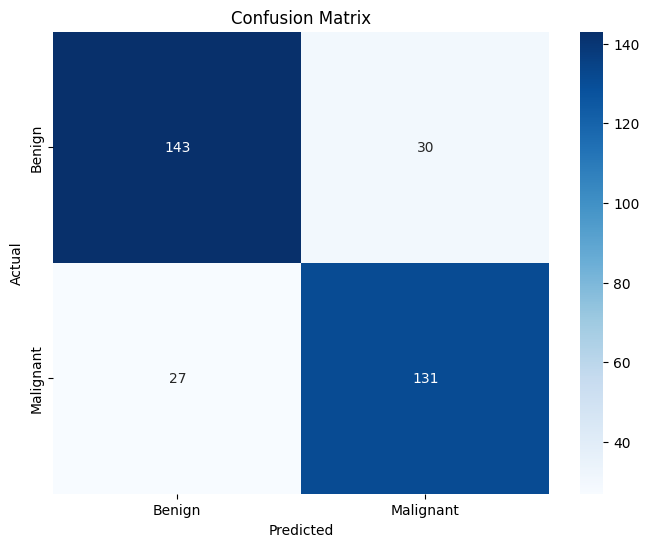

              precision    recall  f1-score   support

      Benign       0.84      0.83      0.83       173
   Malignant       0.81      0.83      0.82       158

    accuracy                           0.83       331
   macro avg       0.83      0.83      0.83       331
weighted avg       0.83      0.83      0.83       331



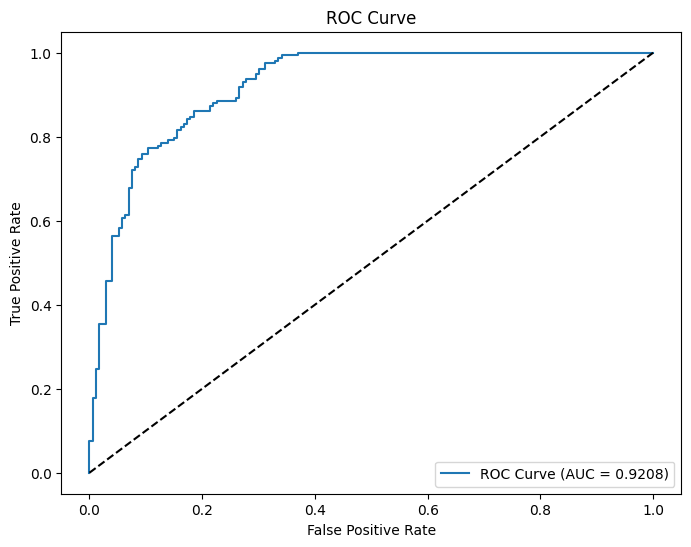

In [27]:
evaluate_model(model2, test_loader)

## Lets Try My own model

In [ ]:
class SkinCancerModel3(nn.Module):
    def __init__(self):
        super(SkinCancerModel3, self).__init__()
        
        # Initial convolution block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding='same'),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2, 2)
        )
        
        # Residual block 1
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(32)
        )
        self.skip1 = nn.Conv2d(16, 32, kernel_size=1, padding='same')  # Adjust channels

        # Residual block 2
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding='same'),
            nn.BatchNorm2d(64)
        )
        self.skip2 = nn.Conv2d(32, 64, kernel_size=1, padding='same')  # Adjust channels

        # Residual block 3
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding='same'),
            nn.BatchNorm2d(128)
        )
        self.skip3 = nn.Conv2d(64, 128, kernel_size=1, padding='same')  # Adjust channels

        # Final layers
        self.pool = nn.MaxPool2d(2, 2)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 128),  # Adjusted for final feature map size
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        # Initial convolution
        x1 = self.conv1(x)
        
        # Residual block 1
        x2 = self.conv2(x1) + self.skip1(x1)  # Skip connection
        x2 = nn.ReLU()(x2)
        x2 = self.pool(x2)

        # Residual block 2
        x3 = self.conv3(x2) + self.skip2(x2)  # Skip connection
        x3 = nn.ReLU()(x3)
        x3 = self.pool(x3)

        # Residual block 3
        x4 = self.conv4(x3) + self.skip3(x3)  # Skip connection
        x4 = nn.ReLU()(x4)
        x4 = self.pool(x4)

        # Classifier
        x = self.classifier(x4)
        return x
        

In [ ]:
!pip install torchsummary

In [ ]:
from torchsummary import summary

model = SkinCancerModel2()
model.to("cuda" if torch.cuda.is_available() else "cpu")
summary(model, input_size=(3, 224, 224))  # Adjust input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]           1,216
       BatchNorm2d-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
         AvgPool2d-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 110, 110]           4,640
              ReLU-6         [-1, 32, 110, 110]               0
           Dropout-7         [-1, 32, 110, 110]               0
         AvgPool2d-8           [-1, 32, 55, 55]               0
            Conv2d-9           [-1, 64, 53, 53]          18,496
      BatchNorm2d-10           [-1, 64, 53, 53]             128
             ReLU-11           [-1, 64, 53, 53]               0
          Dropout-12           [-1, 64, 53, 53]               0
        AvgPool2d-13           [-1, 64, 26, 26]               0
           Conv2d-14          [-1, 128,

In [ ]:
deeper_model = SkinCancerModel3().to(device)


Epoch 1/50: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]

Epoch 1/50, Train Loss: 0.6920, Train Accuracy: 0.6413


Validation Loss: 0.5395, Validation Accuracy: 0.7264
Validation loss improved. Model saved.


Epoch 2/50: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]

Epoch 2/50, Train Loss: 0.6057, Train Accuracy: 0.6803


Validation Loss: 0.4808, Validation Accuracy: 0.7416
Validation loss improved. Model saved.


Epoch 3/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 3/50, Train Loss: 0.5684, Train Accuracy: 0.7198


Validation Loss: 0.5929, Validation Accuracy: 0.6900
No improvement in validation loss. Patience counter: 1


Epoch 4/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 4/50, Train Loss: 0.5751, Train Accuracy: 0.7137


Validation Loss: 0.4800, Validation Accuracy: 0.7690
Validation loss improved. Model saved.


Epoch 5/50: 100%|██████████| 42/42 [00:10<00:00,  3.83it/s]

Epoch 5/50, Train Loss: 0.5410, Train Accuracy: 0.7262


Validation Loss: 0.4803, Validation Accuracy: 0.7477
No improvement in validation loss. Patience counter: 1


Epoch 6/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 6/50, Train Loss: 0.5169, Train Accuracy: 0.7425


Validation Loss: 0.4404, Validation Accuracy: 0.7690
Validation loss improved. Model saved.


Epoch 7/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 7/50, Train Loss: 0.5110, Train Accuracy: 0.7455


Validation Loss: 0.4259, Validation Accuracy: 0.7812
Validation loss improved. Model saved.


Epoch 8/50: 100%|██████████| 42/42 [00:10<00:00,  3.89it/s]

Epoch 8/50, Train Loss: 0.4984, Train Accuracy: 0.7554


Validation Loss: 0.4227, Validation Accuracy: 0.8146
Validation loss improved. Model saved.


Epoch 9/50: 100%|██████████| 42/42 [00:10<00:00,  4.03it/s]

Epoch 9/50, Train Loss: 0.4945, Train Accuracy: 0.7501


Validation Loss: 0.6882, Validation Accuracy: 0.7508
No improvement in validation loss. Patience counter: 1


Epoch 10/50: 100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

Epoch 10/50, Train Loss: 0.4825, Train Accuracy: 0.7539


Validation Loss: 0.4153, Validation Accuracy: 0.8055
Validation loss improved. Model saved.


Epoch 11/50: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]

Epoch 11/50, Train Loss: 0.4795, Train Accuracy: 0.7675


Validation Loss: 0.4013, Validation Accuracy: 0.8359
Validation loss improved. Model saved.


Epoch 12/50: 100%|██████████| 42/42 [00:10<00:00,  4.15it/s]

Epoch 12/50, Train Loss: 0.4738, Train Accuracy: 0.7747


Validation Loss: 0.4594, Validation Accuracy: 0.7781
No improvement in validation loss. Patience counter: 1


Epoch 13/50: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]

Epoch 13/50, Train Loss: 0.4636, Train Accuracy: 0.7797


Validation Loss: 0.4134, Validation Accuracy: 0.7842
No improvement in validation loss. Patience counter: 2


Epoch 14/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 14/50, Train Loss: 0.4735, Train Accuracy: 0.7558


Validation Loss: 0.4481, Validation Accuracy: 0.7842
No improvement in validation loss. Patience counter: 3


Epoch 15/50: 100%|██████████| 42/42 [00:10<00:00,  4.11it/s]

Epoch 15/50, Train Loss: 0.4504, Train Accuracy: 0.7759


Validation Loss: 0.3965, Validation Accuracy: 0.8055
Validation loss improved. Model saved.


Epoch 16/50: 100%|██████████| 42/42 [00:10<00:00,  4.11it/s]

Epoch 16/50, Train Loss: 0.4431, Train Accuracy: 0.7744


Validation Loss: 0.3917, Validation Accuracy: 0.8116
Validation loss improved. Model saved.


Epoch 17/50: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]

Epoch 17/50, Train Loss: 0.4309, Train Accuracy: 0.7945


Validation Loss: 0.3866, Validation Accuracy: 0.8237
Validation loss improved. Model saved.


Epoch 18/50: 100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

Epoch 18/50, Train Loss: 0.4245, Train Accuracy: 0.7994


Validation Loss: 0.3749, Validation Accuracy: 0.8298
Validation loss improved. Model saved.


Epoch 19/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 19/50, Train Loss: 0.4173, Train Accuracy: 0.7876


Validation Loss: 0.3777, Validation Accuracy: 0.8359
No improvement in validation loss. Patience counter: 1


Epoch 20/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 20/50, Train Loss: 0.4249, Train Accuracy: 0.7998


Validation Loss: 0.3674, Validation Accuracy: 0.8511
Validation loss improved. Model saved.


Epoch 21/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 21/50, Train Loss: 0.4252, Train Accuracy: 0.7926


Validation Loss: 0.3644, Validation Accuracy: 0.8632
Validation loss improved. Model saved.


Epoch 22/50: 100%|██████████| 42/42 [00:10<00:00,  3.88it/s]

Epoch 22/50, Train Loss: 0.4086, Train Accuracy: 0.7967


Validation Loss: 0.3695, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 1


Epoch 23/50: 100%|██████████| 42/42 [00:10<00:00,  4.10it/s]

Epoch 23/50, Train Loss: 0.4143, Train Accuracy: 0.7967


Validation Loss: 0.3596, Validation Accuracy: 0.8511
Validation loss improved. Model saved.


Epoch 24/50: 100%|██████████| 42/42 [00:10<00:00,  4.13it/s]

Epoch 24/50, Train Loss: 0.4126, Train Accuracy: 0.7983


Validation Loss: 0.3585, Validation Accuracy: 0.8511
Validation loss improved. Model saved.


Epoch 25/50: 100%|██████████| 42/42 [00:10<00:00,  3.96it/s]

Epoch 25/50, Train Loss: 0.4025, Train Accuracy: 0.8005


Validation Loss: 0.3533, Validation Accuracy: 0.8632
Validation loss improved. Model saved.


Epoch 26/50: 100%|██████████| 42/42 [00:10<00:00,  3.99it/s]

Epoch 26/50, Train Loss: 0.4066, Train Accuracy: 0.8047


Validation Loss: 0.3565, Validation Accuracy: 0.8693
No improvement in validation loss. Patience counter: 1


Epoch 27/50: 100%|██████████| 42/42 [00:10<00:00,  4.06it/s]

Epoch 27/50, Train Loss: 0.4113, Train Accuracy: 0.8062


Validation Loss: 0.3595, Validation Accuracy: 0.8602
No improvement in validation loss. Patience counter: 2


Epoch 28/50: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]

Epoch 28/50, Train Loss: 0.3979, Train Accuracy: 0.8036


Validation Loss: 0.3521, Validation Accuracy: 0.8511
Validation loss improved. Model saved.


Epoch 29/50: 100%|██████████| 42/42 [00:10<00:00,  4.16it/s]

Epoch 29/50, Train Loss: 0.4065, Train Accuracy: 0.8051


Validation Loss: 0.3551, Validation Accuracy: 0.8723
No improvement in validation loss. Patience counter: 1


Epoch 30/50: 100%|██████████| 42/42 [00:10<00:00,  4.15it/s]

Epoch 30/50, Train Loss: 0.4024, Train Accuracy: 0.8119


Validation Loss: 0.3807, Validation Accuracy: 0.8480
No improvement in validation loss. Patience counter: 2


Epoch 31/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 31/50, Train Loss: 0.4071, Train Accuracy: 0.7960


Validation Loss: 0.3473, Validation Accuracy: 0.8511
Validation loss improved. Model saved.


Epoch 32/50: 100%|██████████| 42/42 [00:10<00:00,  4.05it/s]

Epoch 32/50, Train Loss: 0.3945, Train Accuracy: 0.8093


Validation Loss: 0.3603, Validation Accuracy: 0.8754
No improvement in validation loss. Patience counter: 1


Epoch 33/50: 100%|██████████| 42/42 [00:10<00:00,  4.13it/s]

Epoch 33/50, Train Loss: 0.4051, Train Accuracy: 0.8024


Validation Loss: 0.3535, Validation Accuracy: 0.8389
No improvement in validation loss. Patience counter: 2


Epoch 34/50: 100%|██████████| 42/42 [00:10<00:00,  3.94it/s]

Epoch 34/50, Train Loss: 0.3891, Train Accuracy: 0.8100


Validation Loss: 0.3529, Validation Accuracy: 0.8571
No improvement in validation loss. Patience counter: 3


Epoch 35/50: 100%|██████████| 42/42 [00:10<00:00,  4.11it/s]

Epoch 35/50, Train Loss: 0.3931, Train Accuracy: 0.8055


Validation Loss: 0.3501, Validation Accuracy: 0.8632
No improvement in validation loss. Patience counter: 4


Epoch 36/50: 100%|██████████| 42/42 [00:10<00:00,  3.91it/s]

Epoch 36/50, Train Loss: 0.3954, Train Accuracy: 0.8130


Validation Loss: 0.3470, Validation Accuracy: 0.8693
Validation loss improved. Model saved.


Epoch 37/50: 100%|██████████| 42/42 [00:10<00:00,  3.87it/s]

Epoch 37/50, Train Loss: 0.3912, Train Accuracy: 0.8206


Validation Loss: 0.3462, Validation Accuracy: 0.8602
Validation loss improved. Model saved.


Epoch 38/50: 100%|██████████| 42/42 [00:10<00:00,  4.11it/s]

Epoch 38/50, Train Loss: 0.3872, Train Accuracy: 0.8191


Validation Loss: 0.3448, Validation Accuracy: 0.8693
Validation loss improved. Model saved.


Epoch 39/50: 100%|██████████| 42/42 [00:10<00:00,  3.98it/s]

Epoch 39/50, Train Loss: 0.3922, Train Accuracy: 0.8161


Validation Loss: 0.3454, Validation Accuracy: 0.8693
No improvement in validation loss. Patience counter: 1


Epoch 40/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 40/50, Train Loss: 0.3899, Train Accuracy: 0.8119


Validation Loss: 0.3457, Validation Accuracy: 0.8754
No improvement in validation loss. Patience counter: 2


Epoch 41/50: 100%|██████████| 42/42 [00:10<00:00,  4.13it/s]

Epoch 41/50, Train Loss: 0.3891, Train Accuracy: 0.8096


Validation Loss: 0.3439, Validation Accuracy: 0.8784
Validation loss improved. Model saved.


Epoch 42/50: 100%|██████████| 42/42 [00:10<00:00,  3.82it/s]

Epoch 42/50, Train Loss: 0.3939, Train Accuracy: 0.8100


Validation Loss: 0.3425, Validation Accuracy: 0.8663
Validation loss improved. Model saved.


Epoch 43/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 43/50, Train Loss: 0.3890, Train Accuracy: 0.8153


Validation Loss: 0.3420, Validation Accuracy: 0.8663
Validation loss improved. Model saved.


Epoch 44/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 44/50, Train Loss: 0.4009, Train Accuracy: 0.8184


Validation Loss: 0.3424, Validation Accuracy: 0.8693
No improvement in validation loss. Patience counter: 1


Epoch 45/50: 100%|██████████| 42/42 [00:10<00:00,  3.92it/s]

Epoch 45/50, Train Loss: 0.3784, Train Accuracy: 0.8199


Validation Loss: 0.3430, Validation Accuracy: 0.8784
No improvement in validation loss. Patience counter: 2


Epoch 46/50: 100%|██████████| 42/42 [00:10<00:00,  4.04it/s]

Epoch 46/50, Train Loss: 0.3940, Train Accuracy: 0.8081


Validation Loss: 0.3420, Validation Accuracy: 0.8693
Validation loss improved. Model saved.


Epoch 47/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 47/50, Train Loss: 0.3945, Train Accuracy: 0.8172


Validation Loss: 0.3441, Validation Accuracy: 0.8784
No improvement in validation loss. Patience counter: 1


Epoch 48/50: 100%|██████████| 42/42 [00:10<00:00,  3.90it/s]

Epoch 48/50, Train Loss: 0.3817, Train Accuracy: 0.8149


Validation Loss: 0.3426, Validation Accuracy: 0.8632
No improvement in validation loss. Patience counter: 2


Epoch 49/50: 100%|██████████| 42/42 [00:10<00:00,  4.17it/s]

Epoch 49/50, Train Loss: 0.3976, Train Accuracy: 0.8028


Validation Loss: 0.3419, Validation Accuracy: 0.8663
Validation loss improved. Model saved.


Epoch 50/50: 100%|██████████| 42/42 [00:10<00:00,  4.09it/s]

Epoch 50/50, Train Loss: 0.3857, Train Accuracy: 0.8119


Validation Loss: 0.3426, Validation Accuracy: 0.8602
No improvement in validation loss. Patience counter: 1
Loaded best model from checkpoint.


/tmp/ipykernel_36831/2544829555.py:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


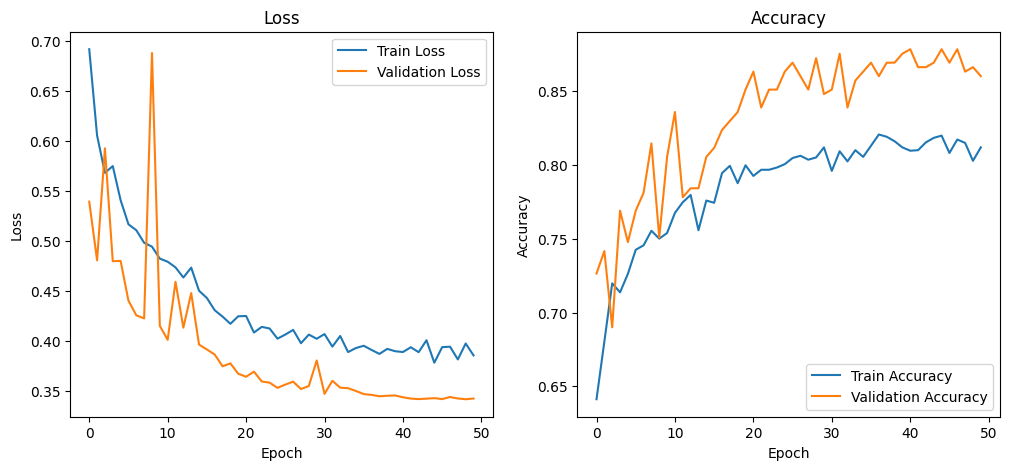

In [ ]:
train_model(deeper_model, train_loader, val_loader, epochs=50)

Test Loss: 0.2894, Test Accuracy: 0.8761


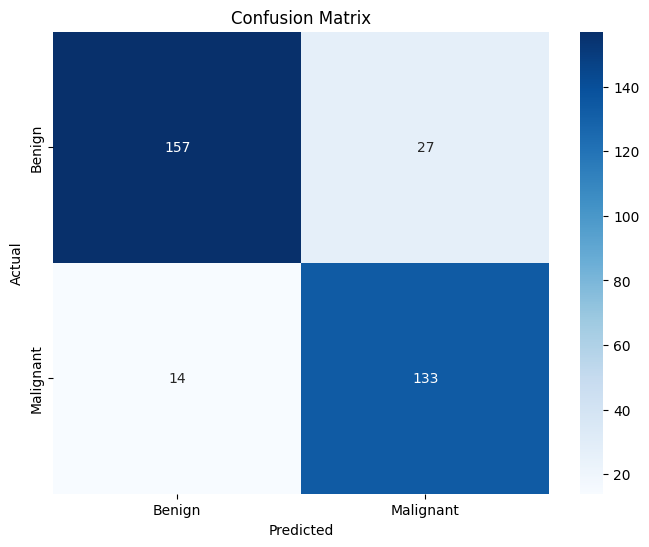

              precision    recall  f1-score   support

      Benign       0.92      0.85      0.88       184
   Malignant       0.83      0.90      0.87       147

    accuracy                           0.88       331
   macro avg       0.87      0.88      0.88       331
weighted avg       0.88      0.88      0.88       331



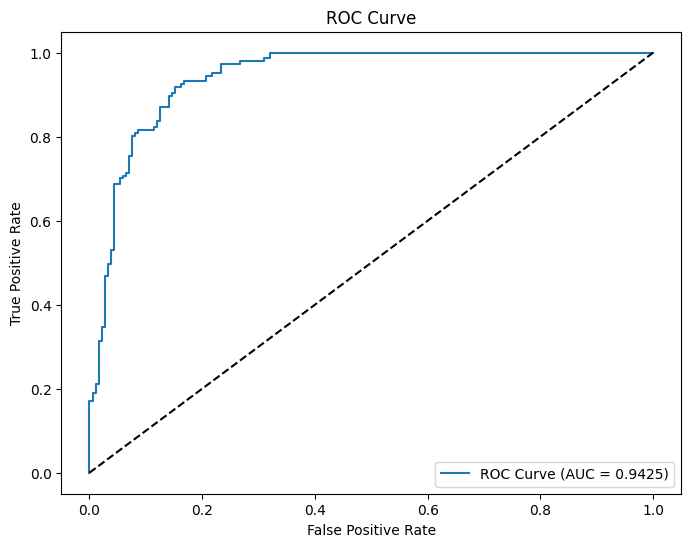

In [ ]:
evaluate_model(deeper_model, test_loader)